In [17]:
import pandas as pd
import numpy as np

df = pd.read_csv('ratings.csv')

In [18]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [19]:
n_users = df.userId.unique().shape[0]
n_items = df.movieId.unique().shape[0]
n_items

9724

In [20]:
#map movieId to indices since movieId's are not consequtive integers
item_ind = {}
lastind = 0
for row in df.itertuples():
    if row[2] in item_ind:
        continue
    else:
        item_ind[row[2]] = lastind
        lastind += 1

In [21]:
ratings = np.zeros((n_users,n_items))
print(ratings.shape)
for row in df.itertuples():
    ratings[row[1]-1,item_ind[row[2]]] = row[3]
ratings

(610, 9724)


array([[4. , 4. , 4. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [2.5, 2. , 0. , ..., 0. , 0. , 0. ],
       [3. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 5. , ..., 3. , 3.5, 3.5]])

In [22]:
print('number of users:',n_users)
print('number of items:',n_items)
sparsity = (float(len(ratings.nonzero()[0])) / float(n_users*n_items)) * 100
print('sparsity: ',sparsity,'%')

number of users: 610
number of items: 9724
sparsity:  1.6999683055613624 %


In [23]:
#take 10 randomly selected ratings from each user and use this as the testing set
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    
    for row in range(n_users):
        ind = ratings[row,:].nonzero()[0]
        nind = len(ind)
        test_ind = np.random.choice(ind,size=10,replace=False)
        train[row,test_ind] = 0.0
        test[row,test_ind] = ratings[row,test_ind]
        
    #make sure training and testing sets are disjoint
    assert(np.all(train*test==0))
    
    return train,test

In [24]:
train,test = train_test_split(ratings)

In [25]:
print(test[609,:].nonzero())
print(train[609,:].nonzero())
print(train.shape)

(array([ 520,  812, 1094, 2949, 2957, 3308, 4794, 7133, 9633, 9669],
      dtype=int64),)
(array([   0,    2,    3, ..., 9721, 9722, 9723], dtype=int64),)
(610, 9724)


In [27]:
import MF
ALS_MF = MF.ExplicitMF(train,n_factors=10,item_reg=0.0,user_reg=0.0,alg='als')

In [28]:
import matplotlib.pyplot as plt

def plot_learning_curve(iter_list,test):
    test_mse,train_mse = ALS_MF.learning_curve(iter_list,test)
    
    plt.figure(figsize=(10,8))
    plt.plot(iter_list,test_mse,'-X',label='Test MSE')
    plt.plot(iter_list,train_mse,'-D',label='Train MSE')
    plt.xlabel('no. of iterations')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

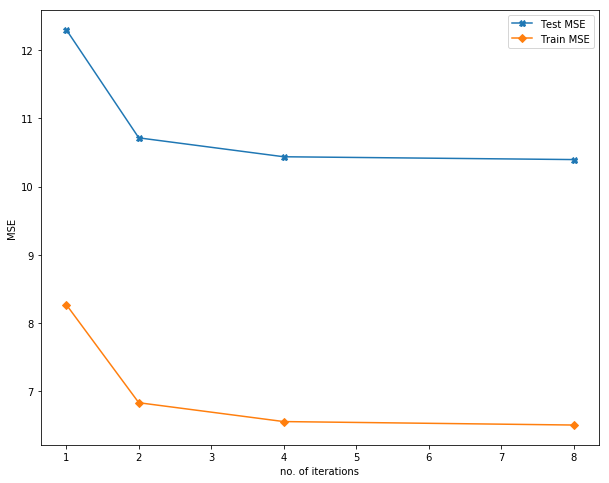

In [29]:
iter_list = []
for i in range(4):
    iter_list.append(2**i)
    
plot_learning_curve(iter_list,test)

In [30]:
#find optimal hyper-params
iter_list = []
for i in range(5):
    iter_list.append(2**i)
    
reg_list = [0.01,0.1,1]
fact_list = [5,10,20,40]

test_mse_mat = np.zeros((len(fact_list),len(reg_list)))
rowcounter = 0
colcounter = 0
for fact in fact_list:
    for reg in reg_list:
        print('iter: ',rowcounter,colcounter)
        
        ALS_MF = MF.ExplicitMF(train,n_factors=fact,item_reg=reg,user_reg=reg)
        
        test_mse,train_mse = ALS_MF.learning_curve(iter_list,test)
        
        test_mse_mat[rowcounter,colcounter] = test_mse[-1]
        
        colcounter += 1
    
    rowcounter += 1
    colcounter = 0
        
ind_opt =  np.unravel_index(np.argmin(test_mse_mat),test_mse_mat.shape)

fact_opt = fact_list[ind_opt[0]]
reg_opt = reg_list[ind_opt[1]]

print('optimal number of factors = ',fact_opt)
print('optimal regularization parameter = ',reg_opt)

iter:  0 0
iter:  0 1
iter:  0 2
iter:  1 0
iter:  1 1
iter:  1 2
iter:  2 0
iter:  2 1
iter:  2 2
iter:  3 0
iter:  3 1
iter:  3 2
optimal number of factors =  40
optimal regularization parameter =  1


In [33]:
opt_fact = 10
opt_reg = 0.01

In [34]:
import MF
ALS_MF = MF.ExplicitMF(train,n_factors=opt_fact,item_reg=opt_reg,user_reg=opt_reg,alg='als')
ALS_MF.train(2**5)

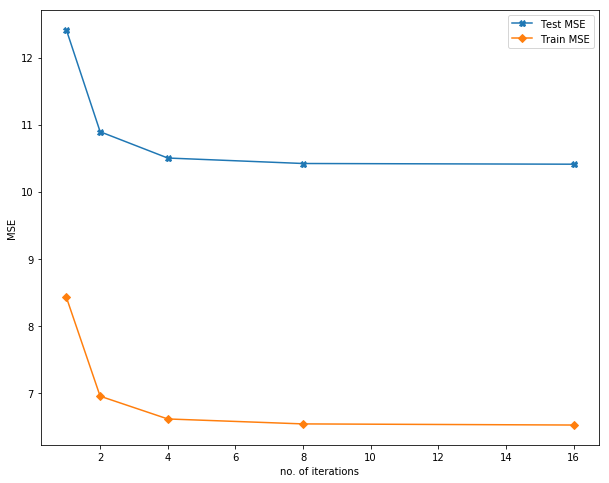

In [35]:
iter_list = []
for i in range(5):
    iter_list.append(2**i)
    
plot_learning_curve(iter_list,test)

In [37]:
from sklearn.metrics.pairwise import cosine_similarity
ALS_sim = cosine_similarity(ALS_MF.item_mat)

In [38]:
def mat_ind_to_movie_ind(mat_ind):
    
    for key,val in item_ind.items():
        if val == mat_ind:
            return key
        
    return False #if code ends up here, this mat_ind is invalid

In [39]:
df_links = pd.read_csv('links.csv')

In [40]:
df_links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [18]:
df_links['tmdbId'].values[2] == 15602

True

In [41]:
#find top 5 recommended movies
def display_top_k_movies(ALS_sim, movie_ind, k=5):
    movie_ind_full = np.argsort(ALS_sim[movie_ind,:])[::-1]
    
    for i in range(k+1):
        curr_ind = movie_ind_full[i]
        
        curr_movie_id = mat_ind_to_movie_ind(curr_ind)
        
        assert(curr_movie_id != False)
        
        ind = np.nonzero(df_links['movieId'].values == curr_movie_id)
        
        #print the original movie also
        if i == 0:
            print('original movie:')
            print('https://www.themoviedb.org/movie/'+str(int(df_links['tmdbId'].values[np.nonzero(df_links['movieId'].values == mat_ind_to_movie_ind(movie_ind))])))
            print('')
            print('similar movies:')
        if i > 0:
            print('https://www.themoviedb.org/movie/'+str(int(df_links['tmdbId'].values[ind])))

In [42]:
movie_id = 56174
item_ind[movie_id]

1053

In [43]:
display_top_k_movies(ALS_sim, item_ind[movie_id], k=5)

original movie:
https://www.themoviedb.org/movie/6479

similar movies:
https://www.themoviedb.org/movie/35
https://www.themoviedb.org/movie/1271
https://www.themoviedb.org/movie/13183
https://www.themoviedb.org/movie/254
https://www.themoviedb.org/movie/1571


In [112]:
np.min(np.abs(ALS_MF.item_mat))

0.0

## SGD

In [5]:
#take 10 randomly selected ratings from each user and use this as the testing set
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    
    for row in range(n_users):
        ind = ratings[row,:].nonzero()[0]
        nind = len(ind)
        test_ind = np.random.choice(ind,size=10,replace=False)
        train[row,test_ind] = 0.0
        test[row,test_ind] = ratings[row,test_ind]
        
    #make sure training and testing sets are disjoint
    assert(np.all(train*test==0))
    
    return train,test

In [6]:
import MF
import pandas as pd
import numpy as np

df = pd.read_csv('ratings.csv')

n_users = df.userId.unique().shape[0]
n_items = df.movieId.unique().shape[0]

#map movieId to indices since movieId's are not consequtive integers
item_ind = {}
lastind = 0
for row in df.itertuples():
    if row[2] in item_ind:
        continue
    else:
        item_ind[row[2]] = lastind
        lastind += 1
        
ratings = np.zeros((n_users,n_items))
print(ratings.shape)
for row in df.itertuples():
    ratings[row[1]-1,item_ind[row[2]]] = row[3]

train,test = train_test_split(ratings)
    
SGD_MF = MF.ExplicitMF(train,n_factors=20,item_reg=0.01,user_reg=0.01,item_bias_reg=0.01,user_bias_reg=0.01,alg='sgd')

(610, 9724)


In [8]:
import matplotlib.pyplot as plt

def plot_learning_curve(iter_list,test):
    test_mse,train_mse = SGD_MF.learning_curve(iter_list,test,learning_rate=0.01)
    
    plt.figure(figsize=(10,8))
    plt.plot(iter_list,test_mse,'-X',label='Test MSE')
    plt.plot(iter_list,train_mse,'-D',label='Train MSE')
    plt.xlabel('no. of iterations')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

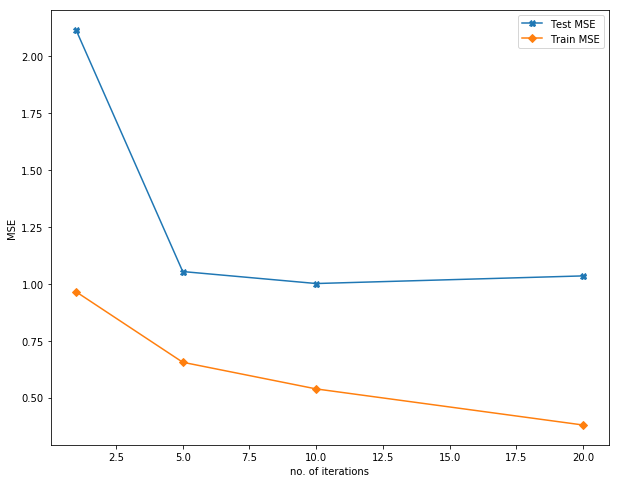

In [4]:
iter_list = [1,5,10,20]
    
plot_learning_curve(iter_list,test)

In [45]:
#find optimal hyperparams via grid-search
fact_vect = [10,40,80]
reg_vect = [0.01,0.1,1]
iter_list = [20,40,80,120]

n = len(fact_vect)
m = len(reg_vect)
test_mse_mat = np.zeros((n,m))

for i in range(n):
    for j in range(m):
            print('iter = ',int(i),int(j)
            
            SGD_MF = MF.ExplicitMF(train,n_factors=fact_vect[i],item_reg=reg_vect[j],user_reg=reg_vect[j],item_bias_reg=reg_vect[j],user_bias_reg=reg_vect[j],alg='sgd')
            
            test_mse,train_mse = SGD_MF.learning_curve(iter_list,test,learning_rate=0.001)
            
            test_mse_mat[i,j] = test_mse[-1]
            
ind_opt =  np.unravel_index(np.argmin(test_mse_mat),test_mse_mat.shape)

opt_fact = fact_vect[ind_opt[0]]
opt_reg = reg_vect[ind_opt[1]]
opt_bias_reg = reg_vect[ind_opt[2]]

print('optimal number of factors = ',opt_fact)
print('optimal regularization parameter = ',opt_reg)
print('optimal bias regularization parameter = ',opt_bias_reg)

iter =  0 0 0
iter =  0 0 1
iter =  0 1 0
iter =  0 1 1
iter =  1 0 0
iter =  1 0 1
iter =  1 1 0
iter =  1 1 1
optimal number of factors =  40
optimal regularization parameter =  10
optimal bias regularization parameter =  20


In [42]:
import multiprocessing as mp
from hyperparam_opt import hyperparam_grid_search

fact_vect = [5,10,40,80]
reg_vect = [0.01,0.1,1]
iter_list = [1,5,10,20,40,80,160,320]
n = len(fact_vect)

pool = mp.Pool(mp.cpu_count())

results = [pool.apply_async(hyperparam_grid_search,args=(i,iter_list,test,train,fact_vect,reg_vect)) for i in range(n)]

output = [p.get() for p in results]

for i in range(n):
    if i == 0:
        final_min = output[i][2]
        final_min_ind_fact = output[i][0]
        final_min_ind_reg = output[i][1]
        final_opt_iter = output[i][3]
    elif i > 0:
        curr_min = output[i][2]
        if curr_min < final_min:
            final_min = curr_min
            final_min_ind_fact = output[i][0]
            final_min_ind_reg = output[i][1]
            final_opt_iter = output[i][3]
            
opt_fact = fact_vect[final_min_ind_fact]
opt_reg = reg_vect[final_min_ind_reg[0]]
print('optimal number of factors = ',opt_fact)
print('optimal regularization parameter = ',opt_reg)
print('optimal number of iterations = ',final_opt_iter)

optimal number of factors =  80
optimal regularization parameter =  0.1
optimal number of iterations =  40


In [43]:
output

[(0, (1,), 0.8233343760693943, 40),
 (1, (1,), 0.8189227567150281, 20),
 (2, (1,), 0.7826445707055417, 20),
 (3, (1,), 0.7818702165957074, 40)]

In [12]:
#opt_fact = 10
#opt_reg = 0.1
#opt_bias_reg = 0.1
opt_fact = 80
opt_reg = 0.1
opt_bias_reg = 0.1
final_opt_iter = 40

SGD_MF = MF.ExplicitMF(train,n_factors=opt_fact,item_reg=opt_reg,user_reg=opt_reg,item_bias_reg=opt_bias_reg,user_bias_reg=opt_bias_reg,alg='sgd')

iter_list = [1,10,20,40,80]
    
plot_learning_curve(iter_list,test)

KeyboardInterrupt: 

In [9]:
def mat_ind_to_movie_ind(mat_ind):
    
    for key,val in item_ind.items():
        if val == mat_ind:
            return key
        
    return False #if code ends up here, this mat_ind is invalid

In [13]:
df_links = pd.read_csv('links.csv')

In [14]:
SGD_MF = MF.ExplicitMF(ratings,n_factors=opt_fact,item_reg=opt_reg,user_reg=opt_reg,item_bias_reg=opt_bias_reg,user_bias_reg=opt_bias_reg,alg='sgd')
SGD_MF.train(final_opt_iter,learning_rate=0.01)

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
SGD_sim = cosine_similarity(SGD_MF.item_mat)

In [51]:
print(SGD_MF.item_mat[0,:])

[ 0.0009014  -0.2406434  -0.03273687 -0.02269815  0.04727213  0.09707042
  0.01112343 -0.04182106 -0.01606831 -0.10742616  0.07535754 -0.05641038
 -0.01572163  0.10598394  0.11623683  0.03746658 -0.06115645 -0.02792902
  0.02578862  0.08442819 -0.09312223  0.01201079  0.05271172 -0.00987986
 -0.07240367  0.19618558 -0.0005091   0.05476887  0.1416792   0.08601538
  0.05253393  0.04203847  0.11683583  0.1838692  -0.07692872 -0.06533562
 -0.03796507 -0.03258677 -0.0386718  -0.02433561  0.0099549  -0.05972484
 -0.05398074  0.06060184  0.152875    0.10847943 -0.02508191  0.01179508
 -0.0704962   0.08070703  0.18799464 -0.01229896 -0.08190789  0.01080476
  0.02513782  0.04917025 -0.12669899  0.13901497  0.01842272  0.0212677
  0.00254595  0.0996884  -0.19154566  0.0583886  -0.08749632 -0.0251718
 -0.022383    0.08602545  0.1135018   0.06126823  0.11896223 -0.17149587
 -0.17344976 -0.06414936 -0.06903093  0.03671732  0.0112386   0.03140717
 -0.07366533 -0.02445025]


In [16]:
#find top 5 recommended movies
def display_top_k_movies(sim, movie_ind, k=5):
    movie_ind_full = np.argsort(sim[movie_ind,:])[::-1]
    
    for i in range(k+1):
        curr_ind = movie_ind_full[i]
        
        curr_movie_id = mat_ind_to_movie_ind(curr_ind)
        
        assert(curr_movie_id != False)
        
        ind = np.nonzero(df_links['movieId'].values == curr_movie_id)
        
        #print the original movie also
        if i == 0:
            print('original movie:')
            print('https://www.themoviedb.org/movie/'+str(int(df_links['tmdbId'].values[np.nonzero(df_links['movieId'].values == mat_ind_to_movie_ind(movie_ind))])))
            print('')
            print('recommended movies:')
        elif i > 0: 
            print('https://www.themoviedb.org/movie/'+str(int(df_links['tmdbId'].values[ind])))

In [24]:
movie_id = 122906
display_top_k_movies(SGD_sim, item_ind[movie_id], k=5)

original movie:
https://www.themoviedb.org/movie/284054

recommended movies:
https://www.themoviedb.org/movie/12268
https://www.themoviedb.org/movie/43137
https://www.themoviedb.org/movie/11023
https://www.themoviedb.org/movie/23988
https://www.themoviedb.org/movie/9389


### Add in implicit preferences

Try to improve recommendation by adding in implicit preferences factor to items.  Let $N(u)$ be the set of items that are implicitly preferred by user $u$.  For item $i$, we have an associated new factor $x_i$.  So a user who showed preference in item $i$ is characterized by $$|N(u)|^{-1/2} \sum_{i \in N(u)} x_i$$

In [1]:
#take 10 randomly selected ratings from each user and use this as the testing set
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    
    for row in range(n_users):
        ind = ratings[row,:].nonzero()[0]
        nind = len(ind)
        test_ind = np.random.choice(ind,size=10,replace=False)
        train[row,test_ind] = 0.0
        test[row,test_ind] = ratings[row,test_ind]
        
    #make sure training and testing sets are disjoint
    assert(np.all(train*test==0))
    
    return train,test

In [2]:
import MF
import pandas as pd
import numpy as np

df = pd.read_csv('ratings.csv')

n_users = df.userId.unique().shape[0]
n_items = df.movieId.unique().shape[0]

#map movieId to indices since movieId's are not consequtive integers
item_ind = {}
lastind = 0
for row in df.itertuples():
    if row[2] in item_ind:
        continue
    else:
        item_ind[row[2]] = lastind
        lastind += 1
        
ratings = np.zeros((n_users,n_items))
print(ratings.shape)
for row in df.itertuples():
    ratings[row[1]-1,item_ind[row[2]]] = row[3]

train,test = train_test_split(ratings)
    
SGD_MF_IP = MF.ExplicitMF(train,n_factors=10,item_reg=0.01,user_reg=0.01,item_bias_reg=0.01,user_bias_reg=0.01,alg='sgd',implicit_pref=True)

(610, 9724)


In [3]:
import matplotlib.pyplot as plt

def plot_learning_curve(iter_list,test,model):
    test_mse,train_mse = model.learning_curve(iter_list,test,learning_rate=0.01)
    
    plt.figure(figsize=(10,8))
    plt.plot(iter_list,test_mse,'-X',label='Test MSE')
    plt.plot(iter_list,train_mse,'-D',label='Train MSE')
    plt.xlabel('no. of iterations')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

In [4]:
iter_list = [1,5,10,20]
    
plot_learning_curve(iter_list,test,SGD_MF_IP)

current iter =  0


C:\Users\George\Documents\ML_SANDBOX\MovieLens\ml-latest-small\ml-latest-small\MF.py:285: RuntimeWarning: overflow encountered in multiply
  result += err*self.item_mat[i,:]
C:\Users\George\Documents\ML_SANDBOX\MovieLens\ml-latest-small\ml-latest-small\MF.py:282: RuntimeWarning: invalid value encountered in double_scalars
  1.0/np.sqrt(numN) * curr_sum_ipm)
C:\Users\George\Documents\ML_SANDBOX\MovieLens\ml-latest-small\ml-latest-small\MF.py:188: RuntimeWarning: invalid value encountered in add
  1.0/np.sqrt(numN)*curr_sum_ipm) - \


KeyboardInterrupt: 

In [ ]:
%debug

> c:\users\george\documents\ml_sandbox\movielens\ml-latest-small\ml-latest-small\mf.py(276)sum_err_along_items()
    274             prediction = self.global_bias + self.user_bias[u] + self.item_bias[i] + \
    275                         self.item_mat[i, :].T.dot(self.user_mat[u, :] + \
--> 276                         1.0/np.sqrt(len(self.ipm)) * curr_sum_ipm)
    277             err = self.ratings[u,i]-prediction
    278             result += err*self.item_mat[i,:]

ipdb> err
nan
ipdb> self.ratings[u,i]
5.0
ipdb> prediction
nan
ipdb> curr_sum_ipm
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan])


## Using SVD

In [28]:
#take 10 randomly selected ratings from each user and use this as the testing set
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    
    for row in range(n_users):
        ind = ratings[row,:].nonzero()[0]
        nind = len(ind)
        test_ind = np.random.choice(ind,size=10,replace=False)
        train[row,test_ind] = 0.0
        test[row,test_ind] = ratings[row,test_ind]
        
    #make sure training and testing sets are disjoint
    assert(np.all(train*test==0))
    
    return train,test

In [29]:
import numpy as np
import pandas as pd
from scipy.sparse.linalg import svds
from scipy.sparse import csc_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

df = pd.read_csv('ratings.csv')

n_users = df.userId.unique().shape[0]
n_items = df.movieId.unique().shape[0]

#map movieId to indices since movieId's are not consequtive integers
item_ind = {}
lastind = 0
for row in df.itertuples():
    if row[2] in item_ind:
        continue
    else:
        item_ind[row[2]] = lastind
        lastind += 1
        
ratings = np.zeros((n_users,n_items))
print(ratings.shape)
for row in df.itertuples():
    ratings[row[1]-1,item_ind[row[2]]] = row[3]

train,test = train_test_split(ratings)

(610, 9724)


In [30]:
#R = csc_matrix(ratings)
Rtrain = csc_matrix(train)

In [31]:
 U, S, VT = svds(Rtrain, k=10)

In [32]:
def get_mse(prediction, observed):
    prediction[observed.nonzero()].flatten()
    observed[observed.nonzero()].flatten()
        
    return mean_squared_error(observed,prediction)

In [33]:
print(U.shape)
print(np.diag(S).shape)
print(VT.shape)

(610, 10)
(10, 10)
(10, 9724)


In [34]:
prediction = U.dot(np.diag(S).dot(VT))
SVD_MSE_train = get_mse(prediction,train)
print(SVD_MSE_train)

SVD_MSE_test = get_mse(prediction,test)
print(SVD_MSE_test)

0.1319795604817947
0.08953488207066403


In [31]:
print(VT == 0)

[[False False False ... False False False]]


In [32]:
def cosine_sim(item_mat):
    sim = item_mat.dot(item_mat.T)
    norms = np.array([np.sort(np.diagonal(sim))])
    print(norms)
    return sim / norms / norms.T

In [35]:
SVD_sim = cosine_similarity(VT.T,VT.T)
print(SVD_sim.shape)

(9724, 9724)


In [36]:
#find top 5 recommended movies
def display_top_k_movies(sim, movie_ind, k=5):
    movie_ind_full = np.argsort(sim[movie_ind,:])[::-1]
    
    for i in range(k+1):
        curr_ind = movie_ind_full[i]
        
        curr_movie_id = mat_ind_to_movie_ind(curr_ind)
        
        assert(curr_movie_id != False)
        
        ind = np.nonzero(df_links['movieId'].values == curr_movie_id)
        
        #print the original movie also
        if i == 0:
            print('original movie:')
            print('https://www.themoviedb.org/movie/'+str(int(df_links['tmdbId'].values[np.nonzero(df_links['movieId'].values == mat_ind_to_movie_ind(movie_ind))])))
            print('')
            print('similar movies:')
        elif i > 0:
            print('https://www.themoviedb.org/movie/'+str(int(df_links['tmdbId'].values[ind])))

In [37]:
def mat_ind_to_movie_ind(mat_ind):
    
    for key,val in item_ind.items():
        if val == mat_ind:
            return key
        
    return False #if code ends up here, this mat_ind is invalid

In [22]:
df_links = pd.read_csv('links.csv')

In [38]:
movie_id = 142448
display_top_k_movies(SVD_sim, item_ind[movie_id], k=5)

original movie:
https://www.themoviedb.org/movie/253412

similar movies:
https://www.themoviedb.org/movie/33909
https://www.themoviedb.org/movie/50839
https://www.themoviedb.org/movie/24253
https://www.themoviedb.org/movie/46503
https://www.themoviedb.org/movie/77866
